In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


'0e2e58b7-1417-49c4-b014-b5efb4b4b831___RS_Erly.B 8256.JPG'   cnn_model.pkl
 cnn_model.h5						      PlantVillage


In [ ]:
import numpy as np
import pickle
import cv2
import tensorflow as tf
import tensorflow.keras
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras

In [ ]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
# print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print(tf.config.list_physical_devices('GPU'))

Version:  2.7.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
directory_root = "E:\Agro-Disease-Detector\PlantVillage_train"
width=64
height=64
depth=3


In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Apple Black rot ...
[INFO] Processing Apple Cedar rust ...
[INFO] Processing Apple healthy ...
[INFO] Processing Apple scab ...
[INFO] Processing Blueberry healthy ...
[INFO] Processing Cherry healthy ...
[INFO] Processing Cherry Powdery mildew ...
[INFO] Processing Corn Cercospora Gray leaf spot ...
[INFO] Processing Corn Common rust ...
[INFO] Processing Corn healthy ...
[INFO] Processing Corn Northern Leaf Blight ...
[INFO] Processing Grape Black rot ...
[INFO] Processing Grape Esca Black Measles ...
[INFO] Processing Grape healthy ...
[INFO] Processing Grape Leaf blight Isariopsis Leaf Spot ...
[INFO] Processing Orange Haunglongbing Citrus greening ...
[INFO] Processing Peach Bacterial spot ...
[INFO] Processing Peach healthy ...
[INFO] Processing Pepper bell Bacterial spot ...
[INFO] Processing Pepper bell healthy ...
[INFO] Processing Potato Early blight ...
[INFO] Processing Potato healthy ...
[INFO] Processing Potato Late blight ...
[

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
print(label_binarizer.classes_)
#print(np_image_list)

['Apple Black rot' 'Apple Cedar rust' 'Apple healthy' 'Apple scab'
 'Blueberry healthy' 'Cherry Powdery mildew' 'Cherry healthy'
 'Corn Cercospora Gray leaf spot' 'Corn Common rust'
 'Corn Northern Leaf Blight' 'Corn healthy' 'Grape Black rot'
 'Grape Esca Black Measles' 'Grape Leaf blight Isariopsis Leaf Spot'
 'Grape healthy' 'Orange Haunglongbing Citrus greening'
 'Peach Bacterial spot' 'Peach healthy' 'Pepper bell Bacterial spot'
 'Pepper bell healthy' 'Potato Early blight' 'Potato Late blight'
 'Potato healthy' 'Raspberry healthy' 'Soybean healthy'
 'Squash Powdery mildew' 'Strawberry Leaf scorch' 'Strawberry healthy'
 'Tomato Bacterial spot' 'Tomato Early blight' 'Tomato Late blight'
 'Tomato Leaf Mold' 'Tomato Septoria leaf spot' 'Tomato Target Spot'
 'Tomato Two spotted spider mite' 'Tomato Yellow Leaf Curl Virus'
 'Tomato healthy' 'Tomato mosaic virus']


In [ ]:
image_size = len(image_list)

In [ ]:
len(image_list)

70295

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 activation_7 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 21, 21, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 64)       

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt,metrics=["accuracy"])
print("[INFO] training network...")

[INFO] training network...


In [ ]:
EPOCHS = 25
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
1757/1757 [==============================] - 172s 90ms/step - loss: 1.4639 - accuracy: 0.5850 - val_loss: 1.3046 - val_accuracy: 0.6561
Epoch 2/25
1757/1757 [==============================] - 171s 97ms/step - loss: 0.6738 - accuracy: 0.7915 - val_loss: 1.3842 - val_accuracy: 0.6729
Epoch 3/25
1757/1757 [==============================] - 158s 90ms/step - loss: 0.5137 - accuracy: 0.8365 - val_loss: 2.7753 - val_accuracy: 0.5451
Epoch 4/25
1757/1757 [==============================] - 182s 103ms/step - loss: 0.4175 - accuracy: 0.8657 - val_loss: 2.7661 - val_accuracy: 0.5484
Epoch 5/25
1757/1757 [==============================] - 174s 99ms/step - loss: 0.3516 - accuracy: 0.8869 - val_loss: 3.6262 - val_accuracy: 0.4854
Epoch 6/25
1757/1757 [==============================] - 173s 98ms/step - loss: 0.3056 - accuracy: 0.9021 - val_loss: 1.1040 - val_accuracy: 0.7585
Epoch 7/25
1757/1757 [==============================] - 179s 102ms/step - loss: 0.2758 - accuracy: 0.9113 - val_loss:

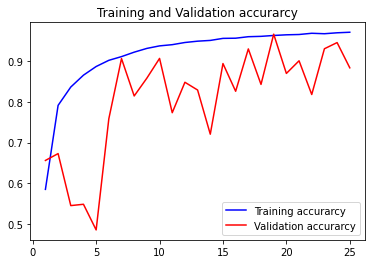

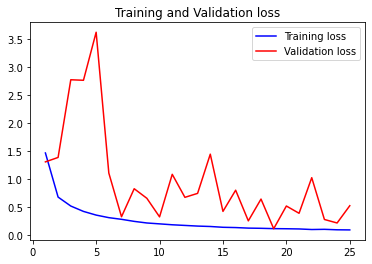

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
440/440 [==============================] - 7s 15ms/step - loss: 0.5196 - accuracy: 0.8837
Test Accuracy: 88.37043642997742


# Save

In [ ]:
model.save('E:\Agro-Disease-Detector\PlantVillage_train\modelonSmallData38C.h5')

In [ ]:
import 
pickle.dump(model,open('E:\Agro-Disease-Detector\PlantVillage_train\modelonSmallData38C.pkl', 'wb'))

**Prediction**

In [ ]:
import os.path
from sklearn import preprocessing
import numpy as np
import pickle
import cv2
import tensorflow as tf
import tensorflow.keras
from os import listdir
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

labels=['Apple Black rot' ,'Apple Cedar rust', 'Apple healthy' ,'Apple scab',
 'Blueberry healthy', 'Cherry Powdery mildew', 'Cherry healthy',
 'Corn Cercospora Gray leaf spot', 'Corn Common rust',
 'Corn Northern Leaf Blight', 'Corn healthy' ,'Grape Black rot',
 'Grape Esca Black Measles' ,'Grape Leaf blight Isariopsis Leaf Spot',
 'Grape healthy', 'Orange Haunglongbing Citrus greening',
 'Peach Bacterial spot', 'Peach healthy', 'Pepper bell Bacterial spot',
 'Pepper bell healthy', 'Potato Early blight', 'Potato Late blight',
 'Potato healthy' ,'Raspberry healthy' ,'Soybean healthy',
 'Squash Powdery mildew', 'Strawberry Leaf scorch', 'Strawberry healthy',
 'Tomato Bacterial spot', 'Tomato Early blight', 'Tomato Late blight',
 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Target Spot',
 'Tomato Two spotted spider mite', 'Tomato Yellow Leaf Curl Virus',
 'Tomato healthy', 'Tomato mosaic virus']
 
model = load_model('/content/drive/MyDrive/Model/CNN_Modelfinal.h5') 


imgpath='/content/drive/MyDrive/Dataset/PlantVillage/testing/Corn Cercospora Gray leaf spot/00120a18-ff90-46e4-92fb-2b7a10345bd3___RS_GLSp 9357.JPG'
lb = preprocessing.LabelBinarizer()

EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
width=64
height=64
depth=3


def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

if os.path.isfile(imgpath):
  import time
  
  start = time.perf_counter()
  imar = convert_image_to_array(imgpath) 
  npimagelist = np.array([imar], dtype=np.float16)/225.0 
  PREDICTEDCLASSES2 = model.predict(npimagelist) 
  print (np.argmax(PREDICTEDCLASSES2))
  #num=np.ndarray.item(np.array([PREDICTEDCLASSES2]))
 # print(labels[num])
  


  end = time.perf_counter()

  elapsed = end - start

  #print('Elapsed %.3f seconds.' % elapsed)
  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence. Elapsed {:.2f} seconds."
    .format(labels[np.argmax(PREDICTEDCLASSES2)], 100 * np.max(PREDICTEDCLASSES2), elapsed)
  )
else:
  print('invalid image path')


7
This image most likely belongs to Corn Cercospora Gray leaf spot with a 94.16 percent confidence. Elapsed 1.21 seconds.
